In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
sensor_loc = pd.read_csv('graph_sensor_locations.csv')
sensor_loc.head(n=10)

,index,sensor_id,latitude,longitude
0,0,773869,34.15497,-118.31829
1,1,767541,34.11621,-118.23799
2,2,767542,34.11641,-118.23819
3,3,717447,34.07248,-118.26772
4,4,717446,34.07142,-118.26572
5,5,717445,34.06913,-118.25932
6,6,773062,34.05368,-118.23369
7,7,767620,34.13486,-118.22932
8,8,737529,34.20264,-118.47352
9,9,717816,34.15562,-118.46860


In [3]:
min_latitude = min(sensor_loc['latitude'])
max_latitude = max(sensor_loc['latitude'])
min_longitude = min(sensor_loc['longitude'])
max_longitude = max(sensor_loc['longitude'])

print(f"Minimum latitude {min_latitude}")
print(f"Maximum latitude {max_latitude}")

print(f"Minimum longitude {min_longitude}")
print(f"Maximum longitude {max_longitude}")

print(f"Centre: {(min_latitude + max_latitude) / 2},{(min_longitude + max_longitude) / 2}")

Minimum latitude 34.04301
Maximum latitude 34.22164
Minimum longitude -118.5368
Maximum longitude -118.1829
Centre: 34.132325,-118.35985


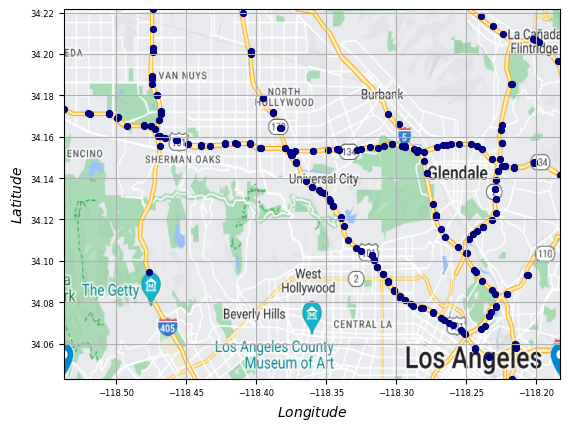

In [4]:
img = plt.imread("background.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-118.5368, -118.1829, 34.04301, 34.22164])
plt.scatter(sensor_loc['longitude'], sensor_loc['latitude'], s=20, c='navy', marker='8')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.tick_params(axis='both', which='minor', labelsize=6)
ax.set_aspect('auto')
plt.grid()

plt.xlabel(r'$Longitude$')
plt.ylabel(r'$Latitude$')

plt.show()

In [5]:
min_selected_longitude = -118.300
max_selected_longitude = -118.220
min_selected_latitude = 34.100
max_selected_latitude = 34.170

sensor_loc.drop(sensor_loc[(sensor_loc['latitude'] > max_selected_latitude)].index, inplace=True)
sensor_loc.drop(sensor_loc[(sensor_loc['latitude'] < min_selected_latitude)].index, inplace=True)
sensor_loc.drop(sensor_loc[(sensor_loc['longitude'] > max_selected_longitude)].index, inplace=True)
sensor_loc.drop(sensor_loc[(sensor_loc['longitude'] < min_selected_longitude)].index, inplace=True)

sensor_loc = sensor_loc.reset_index(drop=True)

In [6]:
# Drop one of the sensors to get a nice round number
sensor_loc.drop([sensor_loc.index[20]], inplace=True)
sensor_loc.drop('index', axis=1, inplace=True)
print(f"Reduced the size to {len(sensor_loc)} sensors")

Reduced the size to 50 sensors


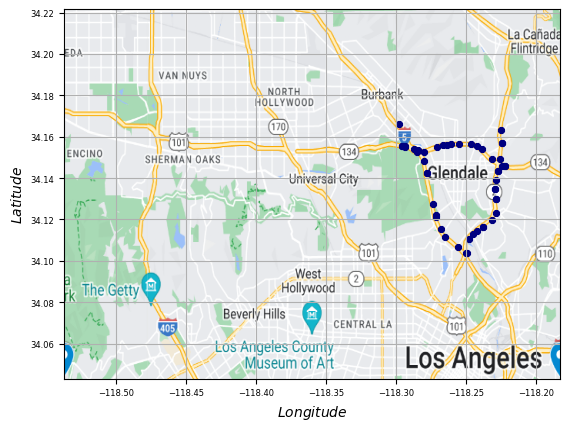

In [7]:
img = plt.imread("background.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-118.5368, -118.1829, 34.04301, 34.22164])
plt.scatter(sensor_loc['longitude'], sensor_loc['latitude'], s=20, c='navy', marker='8')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.tick_params(axis='both', which='minor', labelsize=6)
ax.set_aspect('auto')

plt.xlabel(r'$Longitude$')
plt.ylabel(r'$Latitude$')

plt.grid()
plt.show()

In [8]:
# Find all pairs where the distance is one-sided only
sensor_dist = pd.read_csv('data/sensor_graph/distances_la_2012.csv')
no_dist = sensor_dist[sensor_dist.cost == 0]
no_dist = no_dist[(no_dist['from'] != no_dist['to'])]

no_dist_from = set(no_dist['from'])
no_dist_to = set(no_dist['to'])

# Check if we have no one-sided distances in the selected sensors
no_dist = no_dist_from.union(no_dist_to)
sensor_loc[sensor_loc['sensor_id'].isin(no_dist)]

,sensor_id,latitude,longitude


In [10]:
sensor_loc.iloc[0:-1]['sensor_id'].to_csv('data/sensor_graph/graph_sensor_ids_small.csv',
                               header=False, index=False, lineterminator=',')
sensor_loc.iloc[[-1]]['sensor_id'].to_csv('data/sensor_graph/graph_sensor_ids_small.csv',
                               header=False, index=False, mode='a', lineterminator='')

Sparsity of 0.8291999999999999


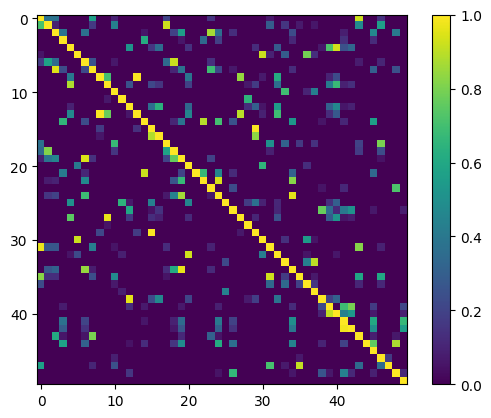

In [18]:
def get_adjacency_matrix(distance_df, sensor_ids, normalized_k=0.1):
    num_sensors = len(sensor_ids)
    dist_mx = np.zeros((num_sensors, num_sensors), dtype=np.float32)
    dist_mx[:] = np.inf
    # Builds sensor id to index map.
    sensor_id_to_ind = {}
    for i, sensor_id in enumerate(sensor_ids):
        sensor_id_to_ind[sensor_id] = i

    # Fills cells in the matrix with distances.
    for row in distance_df.values:
        if row[0] not in sensor_id_to_ind or row[1] not in sensor_id_to_ind:
            continue
        dist_mx[sensor_id_to_ind[row[0]], sensor_id_to_ind[row[1]]] = row[2]

    # Calculates the standard deviation as theta.
    distances = dist_mx[~np.isinf(dist_mx)].flatten()
    std = distances.std()
    adj_mx = np.exp(-np.square(dist_mx / std))
    # Make the adjacent matrix symmetric by taking the max.
    # adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])

    # Sets entries that lower than a threshold, i.e., k, to zero for sparsity.
    adj_mx[adj_mx < normalized_k] = 0
    return sensor_id_to_ind, adj_mx

with open("data/sensor_graph/graph_sensor_ids_small.csv") as f:
        sensor_ids = f.read().strip().split(",")
        
distance_df = pd.read_csv("data/sensor_graph/distances_la_2012.csv", dtype={"from": "str", "to": "str"})
sensor_id_to_ind, adj_mx = get_adjacency_matrix(distance_df, sensor_ids, normalized_k=0.05)

print(f"Sparsity of {1 - (np.count_nonzero(adj_mx) / adj_mx.size)}")
plt.imshow(adj_mx)
plt.colorbar()
plt.show()

In [3]:
sensors = pd.read_csv("data/metr-la.csv")

def encode_time(timestamp):
    week_day = datetime.fromisoformat(timestamp).weekday()    
    week_day_sin = np.sin(2 * np.pi * week_day / 7.0)
    week_day_cos = np.cos(2 * np.pi * week_day / 7.0)
    
    hour = datetime.fromisoformat(timestamp).hour
    hour_sin = np.sin(2 * np.pi * hour / 24.0)
    hour_cos = np.cos(2 * np.pi * hour / 24.0)
    
    return np.array([week_day_sin, week_day_cos, hour_sin, hour_cos])

### Desiderata
1. We capture periodicity in terms of date and in terms of time
2. d(t0, t1) < d(t0, t2) if t1 < t2

In [29]:
def sim(t1, t2, index, decay=0.0, hour_weight=0.6):
    hour_weight = np.clip(hour_weight, 0, 1)

    f1 = encode_time(t1)
    f2 = encode_time(t2)
    
    day_similarity = np.dot(f1[:2], f2[:2]) / (np.linalg.norm(f1[:2]) * np.linalg.norm(f2[:2]))
    hour_similarity = np.dot(f1[2:], f2[2:]) / (np.linalg.norm(f1[2:]) * np.linalg.norm(f2[2:]))
    
    similarity = (hour_similarity * hour_weight + day_similarity * (1 - hour_weight)) * ((1 - decay) ** index)
    return (similarity + 1) / 2

In [47]:
similarities = []
for i, t in enumerate(range(0, 2 * 7 * 24 * 12 + 12)):
    similarities.append(sim(sensors.iloc[0, 0], sensors.iloc[t, 0], i, decay=0, hour_weight=0.7))


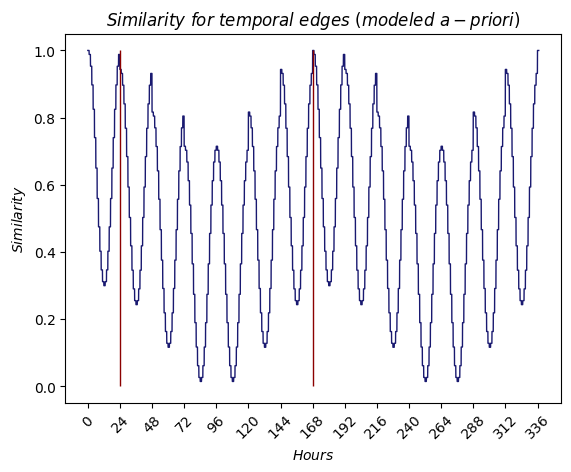

In [48]:
from matplotlib.ticker import FuncFormatter

xs = [i for i, _ in enumerate(similarities)]

formatter = FuncFormatter(lambda x, tick_pos: "${:.0f}$".format(x / 12))

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)
plt.plot(xs, similarities, linewidth=1, color="midnightblue")
plt.xticks(np.arange(0, 2 * 7 * 24 * 12 + 12, 24 * 12), rotation=45)
plt.vlines([288, 2016], 0, 1, linewidth=1, color="darkred")
plt.xlabel(r"$Hours$")
plt.ylabel(r"$Similarity$")
plt.title(r"$Similarity\ for\ temporal\ edges\ (modeled\ a-priori)$")
plt.savefig("time_similarity.png")
plt.show()